In [4]:
!unzip acne_test_final.zip

Archive:  acne_test_final.zip
   creating: images/
   creating: labels/
  inflating: images/levle0_17.jpg    
  inflating: images/levle1_208.jpg   
  inflating: images/levle0_36.jpg    
  inflating: images/levle0_158.jpg   
  inflating: images/levle0_230.jpg   
  inflating: images/levle0_56.jpg    
  inflating: images/levle0_506.jpg   
  inflating: images/levle0_64.jpg    
  inflating: images/levle1_67.jpg    
  inflating: images/levle1_0.jpg     
  inflating: images/levle1_467.jpg   
  inflating: images/levle0_138.jpg   
  inflating: images/levle0_264.jpg   
  inflating: images/levle1_597.jpg   
  inflating: images/levle0_511.jpg   
  inflating: images/levle1_295.jpg   
  inflating: images/levle0_477.jpg   
  inflating: images/levle1_626.jpg   
  inflating: images/levle0_54.jpg    
  inflating: images/levle1_266.jpg   
  inflating: images/levle0_462.jpg   
  inflating: images/levle0_168.jpg   
  inflating: images/levle0_499.jpg   
  inflating: images/levle1_371.jpg   
  inflating: ima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.0 MB/s eta 0:00:00
Cloning into 'deepfillv2_colab'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 99 (delta 2), reused 1 (delta 1), pack-reused 96 (from 1)
Receiving objects: 100% (99/99), 571.56 KiB | 16.81 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Using device: cuda
Found 117 input images


YOLO Detection: 100%|██████████| 117/117 [01:14<00:00,  1.57img/s]


✅ YOLO completed — masks saved in /content/masked
Downloading...
From: https://drive.google.com/u/0/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-&export=download
To: /content/deepfillv2_WGAN_G_epoch40_batchsize4.pth
100% 64.8M/64.8M [00:00<00:00, 261MB/s]


DeepFill v2 Cleaning: 100%|██████████| 117/117 [10:35<00:00,  5.43s/img]


✅ DeepFill completed — cleaned images in /content/cleaned
⏱️ Time per image — min:4.70s  median:5.29s  max:11.80s


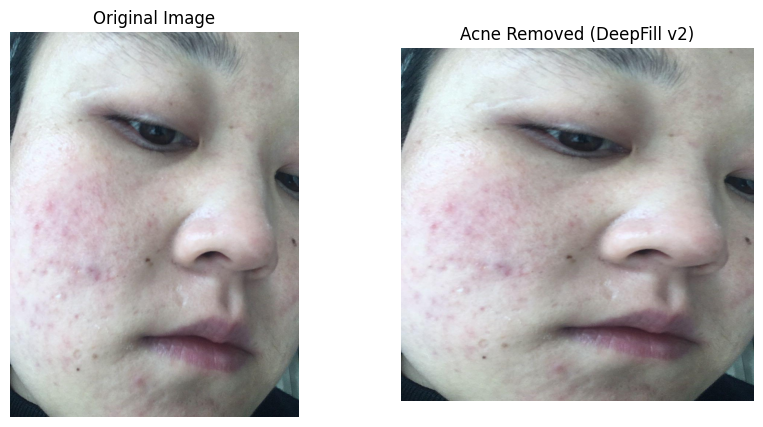

In [5]:
# ============================================
# 🧰 STEP 0 — Setup environment and imports
# ============================================
!pip install ultralytics gdown tqdm -q
!git clone https://github.com/vrindaprabhu/deepfillv2_colab.git

import os, cv2, torch, glob, numpy as np, shutil, subprocess, time
from ultralytics import YOLO
from tqdm import tqdm
import matplotlib.pyplot as plt

# Force GPU usage if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# ============================================
# ⚙️ STEP 1 — Load YOLO acne detection model
# ============================================
yolo_model_path = "/content/best_final.pt"   # your trained acne model
model = YOLO(yolo_model_path)
model.to(device)

# Directory setup
os.makedirs("/content/images", exist_ok=True)
os.makedirs("/content/masked", exist_ok=True)
os.makedirs("/content/cleaned", exist_ok=True)

# ============================================
# 🧩 STEP 2 — Run YOLO & create acne masks
# ============================================
image_files = glob.glob("/content/images/*.jpg") + glob.glob("/content/images/*.png")
print(f"Found {len(image_files)} input images")

for img_path in tqdm(image_files, desc="YOLO Detection", unit="img"):
    img = cv2.imread(img_path)
    H, W, _ = img.shape
    results = model.predict(img, conf=0.3, device=device, verbose=False)[0]

    mask = np.zeros((H, W), dtype=np.uint8)
    for box in results.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

    # Optional dilation for smoother inpainting
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    base = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(f"/content/masked/{base}_input.png", img)
    cv2.imwrite(f"/content/masked/{base}_mask.png", mask)

print("✅ YOLO completed — masks saved in /content/masked")

# ============================================
# 🎨 STEP 3 — Setup DeepFill v2 model
# ============================================
!gdown "https://drive.google.com/u/0/uc?id=1uMghKl883-9hDLhSiI8lRbHCzCmmRwV-&export=download"
!mv deepfillv2_WGAN_G_epoch40_batchsize4.pth deepfillv2_colab/model/deepfillv2_WGAN.pth

# ============================================
# 🧠 STEP 4 — Run DeepFill v2 via CLI for each image
# ============================================
input_dir = "/content/masked"
output_dir = "/content/cleaned"
os.makedirs(output_dir, exist_ok=True)

pairs = [f for f in os.listdir(input_dir) if f.endswith("_input.png")]
timings = []

for file in tqdm(pairs, desc="DeepFill v2 Cleaning", unit="img"):
    base = file.replace("_input.png", "")
    img_path = os.path.join(input_dir, f"{base}_input.png")
    mask_path = os.path.join(input_dir, f"{base}_mask.png")

    # Copy to DeepFill input folder
    shutil.copy(img_path, "/content/deepfillv2_colab/input/input_img.png")
    shutil.copy(mask_path, "/content/deepfillv2_colab/input/mask.png")

    t0 = time.perf_counter()
    subprocess.run(["python", "inpaint.py"], cwd="/content/deepfillv2_colab", check=True)
    t1 = time.perf_counter()
    timings.append(t1 - t0)

    shutil.move("/content/deepfillv2_colab/output/inpainted_img.png",
                f"{output_dir}/{base}_cleaned.png")

print(f"✅ DeepFill completed — cleaned images in /content/cleaned")
print(f"⏱️ Time per image — min:{min(timings):.2f}s  median:{np.median(timings):.2f}s  max:{max(timings):.2f}s")

# ============================================
# 🖼️ STEP 5 — Display sample result
# ============================================
sample = os.listdir("/content/cleaned")[0]
img1 = cv2.cvtColor(cv2.imread(f"/content/masked/{sample.replace('_cleaned.png','_input.png')}"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(f"/content/cleaned/{sample}"), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img1); plt.title("Original Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img2); plt.title("Acne Removed (DeepFill v2)"); plt.axis("off")
plt.show()


In [6]:
!zip -r /content/cleaned.zip /content/cleaned

from google.colab import files
files.download('/content/cleaned.zip')

  adding: content/cleaned/ (stored 0%)
  adding: content/cleaned/levle1_0_cleaned.png (deflated 6%)
  adding: content/cleaned/levle0_403_cleaned.png (deflated 2%)
  adding: content/cleaned/levle0_264_cleaned.png (deflated 2%)
  adding: content/cleaned/levle1_421_cleaned.png (deflated 1%)
  adding: content/cleaned/levle0_413_cleaned.png (deflated 2%)
  adding: content/cleaned/levle1_321_cleaned.png (deflated 1%)
  adding: content/cleaned/levle0_328_cleaned.png (deflated 2%)
  adding: content/cleaned/levle0_509_cleaned.png (deflated 2%)
  adding: content/cleaned/levle1_98_cleaned.png (deflated 4%)
  adding: content/cleaned/levle0_499_cleaned.png (deflated 2%)
  adding: content/cleaned/levle1_371_cleaned.png (deflated 1%)
  adding: content/cleaned/levle1_599_cleaned.png (deflated 1%)
  adding: content/cleaned/levle1_381_cleaned.png (deflated 2%)
  adding: content/cleaned/levle1_626_cleaned.png (deflated 1%)
  adding: content/cleaned/levle0_64_cleaned.png (deflated 4%)
  adding: content/cl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 Using device: cuda
📤 Please upload a face image to clean acne:


Saving testing2.jpeg to testing2 (2).jpeg
Files in /content/images: ['levle0_413.jpg', 'levle0_158.jpg', 'levle0_316.jpg', 'levle0_54.jpg', 'levle0_143.jpg', 'levle0_359.jpg', 'levle1_166.jpg', 'levle0_168.jpg', 'levle1_300.jpg', 'levle1_247.jpg', 'levle1_288.jpg', 'levle0_214.jpg', 'testing (1).jpeg', 'levle0_441.jpg', 'levle0_355.jpg', 'levle0_510.jpg', 'levle1_404.jpg', 'levle1_261.jpg', 'levle1_427.jpg', 'levle1_222.jpg', 'levle0_28.jpg', 'levle0_497.jpg', 'levle1_149.jpg', 'levle1_8.jpg', 'levle1_45.jpg', 'levle1_44.jpg', 'levle1_625.jpg', 'levle0_511.jpg', 'levle1_472.jpg', 'levle0_230.jpg', 'levle1_485.jpg', 'levle0_56.jpg', 'levle0_272.jpg', 'levle0_16.jpg', 'levle1_402.jpg', 'levle0_304.jpg', 'levle1_257.jpg', 'levle1_446.jpg', 'levle1_199.jpg', 'levle1_381.jpg', 'levle0_506.jpg', 'levle1_600.jpg', 'levle1_161.jpg', 'levle0_516.jpg', 'levle1_345.jpg', 'levle0_342.jpg', 'levle1_203.jpg', 'levle0_206.jpg', 'levle1_56.jpg', 'levle1_575.jpg', 'levle1_17.jpg', 'levle1_210.jpg', 'le

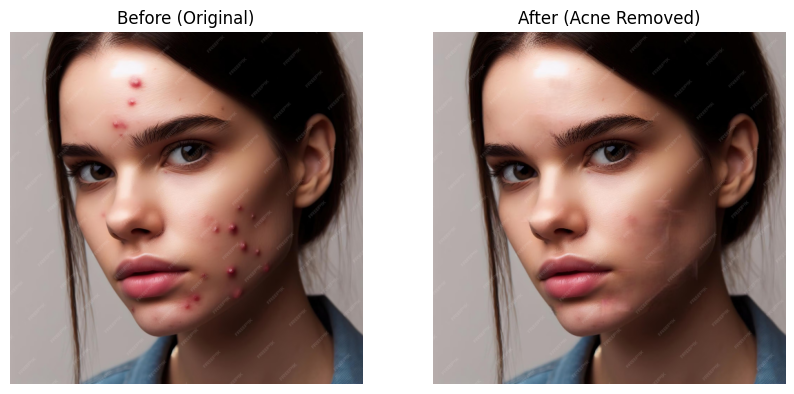

In [11]:
# ======================================================
# 💡 Lightweight version (no re-clone / re-install)
# ======================================================
import os, cv2, torch, shutil, subprocess, time, numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from ultralytics import YOLO

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# Load YOLO model (already trained)
model = YOLO("/content/best_final.pt").to(device)

# Create directories if missing
os.makedirs("/content/images", exist_ok=True)
os.makedirs("/content/masked", exist_ok=True)
os.makedirs("/content/cleaned", exist_ok=True)

# ======================================================
# 📤 STEP 1 — Upload a face image
# ======================================================
print("📤 Please upload a face image to clean acne:")
uploaded = files.upload()

# Check if any files were uploaded
if not uploaded:
    print("No files were uploaded. Please try again.")
else:
    # Get the list of uploaded file names
    uploaded_files = list(uploaded.keys())

    # Print the files in the images directory for debugging
    print("Files in /content/images:", os.listdir("/content/images"))

    # Assuming the first uploaded file is the one to process
    img_name = uploaded_files[0]
    img_path = f"/content/images/{img_name}"

    # Save the uploaded file to the images directory
    with open(img_path, 'wb') as f:
        f.write(uploaded[img_name])

    print(f"✅ Uploaded and saved: {img_name}")

    # ======================================================
    # 🧩 STEP 2 — Run YOLO detection and create mask
    # ======================================================
    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {img_path}. Please check the file path and format.")
    else:
        H, W, _ = img.shape
        results = model.predict(img, conf=0.05, device=device, verbose=False)[0]

        mask = np.zeros((H, W), dtype=np.uint8)
        for box in results.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

        # Optional: slightly dilate for smoother fill
        kernel = np.ones((7,7), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=3)

        base = os.path.splitext(img_name)[0]
        masked_img = f"/content/masked/{base}_input.png"
        masked_mask = f"/content/masked/{base}_mask.png"

        cv2.imwrite(masked_img, img)
        cv2.imwrite(masked_mask, mask)
        print("✅ Mask created successfully")

        # ======================================================
        # 🧠 STEP 3 — Run DeepFill v2 inpainting
        # ======================================================
        shutil.copy(masked_img, "/content/deepfillv2_colab/input/input_img.png")
        shutil.copy(masked_mask, "/content/deepfillv2_colab/input/mask.png")

        print("🎨 Running DeepFill v2 (this may take a few seconds)...")
        start = time.perf_counter()
        subprocess.run(["python", "inpaint.py"], cwd="/content/deepfillv2_colab", check=True)
        end = time.perf_counter()

        cleaned_img = f"/content/cleaned/{base}_cleaned.png"
        shutil.move("/content/deepfillv2_colab/output/inpainted_img.png", cleaned_img)
        print(f"✅ Done! (inpainting time: {end-start:.2f}s)")

        # ======================================================
        # 🖼️ STEP 4 — Display before vs after
        # ======================================================
        img_before = cv2.cvtColor(cv2.imread(masked_img), cv2.COLOR_BGR2RGB)
        img_after  = cv2.cvtColor(cv2.imread(cleaned_img), cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1); plt.imshow(img_before); plt.title("Before (Original)"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(img_after);  plt.title("After (Acne Removed)"); plt.axis("off")
        plt.show()